# Import Libraries

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import psycopg2
from sqlalchemy import create_engine, inspect
import seaborn as sns
import matplotlib.pyplot as plt

import re
import warnings
warnings.filterwarnings('ignore')
import tqdm
import random

import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
pd.set_option('max_rows', 250)
pd.set_option('display.max_colwidth', 1000)

In [5]:

def ingest_data(list_of_cities,list_of_files):


    folder_path = "data"

    df_dic = {}
    geojson_list =[]
    for city in list_of_cities:

        # List all files in the folder
        full_path = folder_path +'/'+ city 
        files = os.listdir(full_path  )
        for file in files:
            if file in list_of_files:
                df=pd.DataFrame()
                if file.endswith(('.gz')):
                    df = pd.read_csv(full_path + '/' + file , compression='gzip')
                elif file.endswith(('.geojson')):
                    with open(os.path.join(full_path, file)) as f:
                        data = json.load(f)
                        geojson_list.append((city,snapshot,file, data))
                elif file.endswith(('.csv')):
                    df = pd.read_csv(full_path + '/' + file )
                df['city'] = city
                df['file']=file

                if file.endswith(('.gz', '.csv')):
                    if file.replace(".",'_') in df_dic:
                        df_dic[file.replace(".",'_')]= pd.concat([df_dic[file.replace(".",'_')],df]) \
                                                         .drop_duplicates()
                    else: 
                        df_dic[file.replace(".",'_')]=df
                    print(full_path + '/' + file)


    # Saving it to pickle as an intermediary step

    for key in df_dic:
            # Shuffle the data
        df_dic[key] = df_dic[key].sample(frac=1).reset_index(drop=True)
        df_dic[key].to_pickle(key + ".pkl")
        print (key, 'Save as pickle')
    
    return
    


In [6]:
list_of_cities =  [
    'asheville',
    'austin',
    'boston',
    'broward-county',
    'cambridge',
    'chicago',
    'clark-county',
    'columbus',
    'dallas',
    'denver',
    'hawaii',
    'jersey-city',
    'los-angeles',
    'nashville',
    'new-orleans',
    'new-york-city',
    'oakland',
    'pacific-grove',
    'palm-springs',
    'philadelphia',
    'portland',
    'raleigh',
    'salem',
    'san-clara-county',
    'san-diego',
    'san-francisco',
    'san-mateo-county',
    'santa-cruz-county',
    'santa-monica',
    'seattle',
    'twin-cities',
    'washington-dc'
]

ingest_data(list_of_cities,list_of_files)

data/asheville/listings.csv.gz
data/austin/listings.csv.gz
data/boston/listings.csv.gz
data/broward-county/listings.csv.gz
data/cambridge/listings.csv.gz
data/chicago/listings.csv.gz
data/clark-county/listings.csv.gz
data/columbus/listings.csv.gz
data/dallas/listings.csv.gz
data/denver/listings.csv.gz
data/hawaii/listings.csv.gz
data/jersey-city/listings.csv.gz
data/los-angeles/listings.csv.gz
data/nashville/listings.csv.gz
data/new-orleans/listings.csv.gz
data/new-york-city/listings.csv.gz
data/oakland/listings.csv.gz
data/pacific-grove/listings.csv.gz
data/portland/listings.csv.gz
data/salem/listings.csv.gz
data/san-diego/listings.csv.gz
data/san-francisco/listings.csv.gz
data/san-mateo-county/listings.csv.gz
data/santa-cruz-county/listings.csv.gz
data/seattle/listings.csv.gz
data/twin-cities/listings.csv.gz
data/washington-dc/listings.csv.gz
listings_csv_gz Save as pickle


In [7]:
listings_csv_gz =pd.read_pickle('listings_csv_gz.pkl')

keep_cols = [ 'neighbourhood_cleansed',
             'property_type' , 
             'room_type', 
             'accommodates',
             'bathrooms_text',
             'bedrooms',
             'beds', 
             #'amenities',
             #'review_scores_rating' 
             'review_scores_value',
             'price',  
             'city']

def trim_and_encode_listings(listings_csv_gz, keep_cols ):
    # Fix pricing
    listings_csv_gz.price = listings_csv_gz.price.replace(',','',regex=True
                                                     ).replace('\$','',regex=True).astype('float')



    # Also Trim columns with no reviews to remove inactive properties
    trimmed_listings = listings_csv_gz.dropna(subset=[
                                               'first_review'], how='all', inplace=False)


    # drop rows where bathrooms text, bedrooms or beds are null
    trimmed_listings = trimmed_listings.dropna(subset=[
                                                'bathrooms_text',
                                                'bedrooms',
                                                'beds',
                                                'review_scores_value'],how='any', inplace=False)
    
    trimmed_listings = trimmed_listings[keep_cols]
    trimmed_listings = trimmed_listings[trimmed_listings.review_scores_value > 4.5]
#     trimmed_listings = trimmed_listings[trimmed_listings.room_type == 'Entire home/apt']
#     trimmed_listings = trimmed_listings[trimmed_listings.property_type.isin(['Entire rental unit',
#                                                                              'Entire home',
#                                                                              'Entire rental unit',
#                                                                              'Entire home',
#                                                                              'Entire condo',
#                                                                              'Entire guesthouse',
#                                                                              'Entire townhouse',
#                                                                              'Entire serviced apartment',
#                                                                              'Entire loft'])]
                                                                             

    
    def extract_numeric_value(series):

        numeric_series = series.apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
        numeric_series = numeric_series.apply(lambda x: float(x[0]) if len(x) > 0 else 0)
        return numeric_series


    # Get integer in text:    
    trimmed_listings.bathrooms_text =  extract_numeric_value(trimmed_listings.bathrooms_text)
    
    
    
    
    
    return trimmed_listings
    

In [8]:
trimmed_listings = trim_and_encode_listings(listings_csv_gz, keep_cols )

In [9]:
# recover listints from pickle
# listings_csv_gz =pd.read_pickle('listings_csv_gz.pkl')


# Fix pricing
# listings_csv_gz.price = listings_csv_gz.price.replace(',','',regex=True
#                                                      ).replace('\$','',regex=True).astype('float')



# # Also Trim columns with no reviews to remove inactive properties
# trimmed_listings = listings_csv_gz.dropna(subset=[
#                                                'first_review'], how='all', inplace=False)


# # drop rows where bathrooms text, bedrooms or beds are null
# trimmed_listings = trimmed_listings.dropna(subset=[
#                                                 'bathrooms_text',
#                                                 'bedrooms',
#                                                 'beds'],how='any', inplace=False)


# keep_cols = [ 'neighbourhood_cleansed',
#              'property_type' , 
#              'room_type', 
#              'accommodates',
#              'bathrooms_text',
#              'bedrooms',
#              'beds', 
#              #'amenities',
#              'price',  
#              'city']

# trimmed_listings = trimmed_listings[keep_cols]
# trimmed_listings = trimmed_listings[trimmed_listings.room_type == 'Entire home/apt']


# create staging pickle to be used as based for Feature engineering.

#trimmed_listings.to_pickle('trimmed_listings.pkl')
# del listings_csv_gz

In [10]:
# def extract_numeric_value(series):
#     numeric_series = series.apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
#     numeric_series = numeric_series.apply(lambda x: float(x[0]) if len(x) > 0 else 0)
#     return numeric_series


# # Get integer in text:    
# trimmed_listings.bathrooms_text =  extract_numeric_value(trimmed_listings.bathrooms_text)


# def count_lists(series):
#     return series.map(lambda x: 0 if eval(x)== None else len(eval(x)))    

# # Count Items in list:
# for field in ['amenities']:
#     trimmed_listings[field] = count_lists(trimmed_listings[field])



## Preprocess

In [11]:
def encoded_listings(df):
    

    def one_hot_encode(df, column_name):
        df_encoded = pd.get_dummies(df, columns=[column_name], prefix=[column_name], drop_first=True)
        return df_encoded

    # one hot encode:
    for column_name in ['room_type', 'neighbourhood_cleansed','city', 'property_type' ]:
        df = one_hot_encode(df, column_name)

    df.head().to_csv('encoded_listings.csv',index=False)

    return df

<AxesSubplot:>

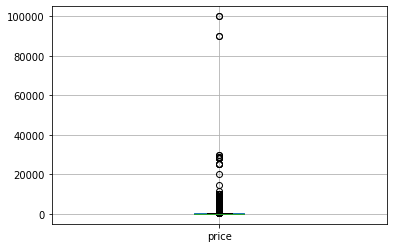

In [12]:
trimmed_listings.boxplot(column='price')

4) Create a Grid-Search Function to enable efficient model selection

In [14]:
# def model_grid_search(df, selected_models=None, cv=5, test_size=0.2, n_estimators =[50, 100, 200]):
#     # Separate features (X) and target variable (y)
#     X = df.drop('price', axis=1)
#     y = df['price']

#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#     # Perform feature scaling
#     scaler = MinMaxScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Define the regression models with their parameter grids
#     regressors = {
#         'Linear Regression': (LinearRegression(), {}),
#         'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
#         'Lasso': (Lasso(tol=0.001, max_iter=2000), {'alpha': [0.1, 1.0, 10.0]}),
#         'ElasticNet': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]}),
#         'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 20]}),
#         'Random Forest': (RandomForestRegressor(), {'n_estimators': n_estimators}),
#         'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}),
#         'XGBoost': (XGBRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
#         'LightGBM': (LGBMRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
#         'k-NN': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 10, 100]}),
#         'Neural Network': (MLPRegressor(), {'hidden_layer_sizes': [(100,), (100, 100), (50, 50, 50)]})
#     }

#     # train and evaluate each selected regression 
#     results = {'RMSE': [], 'R-squared': [], 'Best Parameters': [], 'elapsed_time': []}

#     if selected_models is None:
#         selected_models = regressors.keys()

#     for name, (regressor, param_grid) in regressors.items():
#         if name in selected_models:
#             start = datetime.datetime.now()
#             print('Starting ', name, ' - ', start)
#             grid_search = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error', cv=cv)
#             grid_search.fit(X_train_scaled, y_train)
#             best_estimator = grid_search.best_estimator_
#             best_params = grid_search.best_params_
#             predictions = best_estimator.predict(X_test_scaled)
#             rmse = np.sqrt(mean_squared_error(y_test, predictions))
#             r2 = r2_score(y_test, predictions)
#             results['RMSE'].append(rmse)
#             results['R-squared'].append(r2)
#             results['Best Parameters'].append(best_params)
            
#             end = datetime.datetime.now()
#             elapsed_time = end - start
#             results['elapsed_time'].append(elapsed_time)
            
#             print(name, 'regression complete - ', end, 'elapsed: ', elapsed_time, '-', r2)

#     # Create table
#     results_df = pd.DataFrame(results, index=selected_models)
    
#     return results_df

In [15]:
def remove_outliers_and_save_model( high_cut_off, low_cut_off = 10, no_eval = True):
    selected_models = [#'Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 
                       'LightGBM']
    
    # Filtering out records outside the low and high cut-off range
    filtered_data = trimmed_listings[(trimmed_listings.price >= low_cut_off) & (trimmed_listings.price <= high_cut_off)]
    
    # Counting excluded records
    excluded = len(trimmed_listings) - len(filtered_data)
    print(excluded, 'records excluded')
    print(len(filtered_data), 'records included')
    filtered_data.to_pickle('filtered_data')
    
    if no_eval== False:
    # Perform model grid search on the filtered data
        results = model_grid_search(encoded_listings(filtered_data), selected_models=selected_models)

        results['low_cut_off'] = low_cut_off
        results['high_cut_off'] = high_cut_off
        results['excluded'] = excluded
        #results.to_pickle('results_{}_{}.pkl'.format(low_cut_off, high_cut_off))
        
        return_value= results, filtered_data
    
    else:
        return_value=  filtered_data
    
    return return_value


In [16]:
# high_cut_off = 700
# low_cut_off =0
# cleaned_data = remove_outliers (high_cut_off, low_cut_off, no_eval =False )

In [17]:




# for high_cut_off in [2500, 2000, 1500, 1000,700,600]:
#     for low_cut_off in [0, 15,20,30, 40, 50]:
#         print('\n====== High:', high_cut_off, '- ===== Low:',low_cut_off)
#         remove_outliers (high_cut_off, low_cut_off, no_eval =False )

In [18]:
def model_grid_search(df, selected_models=None, cv=5, test_size=0.2, n_estimators=[50, 100, 200]):


    # Separate features (X) and target variable (y)
    X = df.drop('price', axis=1)
    y = df['price']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Perform feature scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the regression models with their parameter grids
    regressors = {
        'Linear Regression': (LinearRegression(), {}),
        'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
        'Lasso': (Lasso(tol=0.001, max_iter=2000), {'alpha': [0.1, 1.0, 10.0]}),
        'ElasticNet': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]}),
        'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 20]}),
        'Random Forest': (RandomForestRegressor(), {'n_estimators': n_estimators}),
        'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
        'XGBoost': (XGBRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
        'LightGBM': (LGBMRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
        'k-NN': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 10, 100]}),
        'Neural Network': (MLPRegressor(), {'hidden_layer_sizes': [(100,), (100, 100), (50, 50, 50)]})
    }

    # Train and evaluate each selected regression 
    results = {'RMSE': [], 'R-squared': [], 'Best Parameters': [], 'elapsed_time': []}

    if selected_models is None:
        selected_models = regressors.keys()

    for name in selected_models:
        regressor, param_grid = regressors[name]
        start = datetime.datetime.now()
        print('Starting ', name, ' - ', start)
        grid_search = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error', cv=cv)
        grid_search.fit(X_train_scaled, y_train)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        predictions = best_estimator.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        results['RMSE'].append(rmse)
        results['R-squared'].append(r2)
        results['Best Parameters'].append(best_params)
        
        end = datetime.datetime.now()
        elapsed_time = end - start
        results['elapsed_time'].append(elapsed_time)
        
        print(name, 'regression complete - ', end, 'elapsed: ', elapsed_time, '-', r2)

        # Save the best performing model
        model_filename = f"{name.lower().replace(' ', '-')}_prod_model.pkl"
        joblib.dump(best_estimator, model_filename)

    # Create table
    results_df = pd.DataFrame(results, index=selected_models)
    
    return results_df

In [19]:

for high_cut_off in [2000, 1500, 1000,700]:
    for low_cut_off in [0, 15,30, 45]:
        print('\n====== High:', high_cut_off, '- ===== Low:',low_cut_off)
        remove_outliers (high_cut_off, low_cut_off, no_eval =False )


====== High: 2000 - ===== Low: 0
514 records excluded
124368 records included
Starting  LightGBM  -  2023-12-03 20:28:09.101336
LightGBM regression complete -  2023-12-03 20:30:17.703122 elapsed:  0:02:08.601786 - 0.5638900790831248

====== High: 2000 - ===== Low: 15
544 records excluded
124338 records included
Starting  LightGBM  -  2023-12-03 20:30:25.141541
LightGBM regression complete -  2023-12-03 20:32:15.125135 elapsed:  0:01:49.983594 - 0.563855660185334

====== High: 2000 - ===== Low: 30
618 records excluded
124264 records included
Starting  LightGBM  -  2023-12-03 20:32:21.390691
LightGBM regression complete -  2023-12-03 20:34:12.328229 elapsed:  0:01:50.937538 - 0.5761586318293364

====== High: 2000 - ===== Low: 45
1039 records excluded
123843 records included
Starting  LightGBM  -  2023-12-03 20:34:18.617960
LightGBM regression complete -  2023-12-03 20:36:19.096478 elapsed:  0:02:00.478518 - 0.571462660515377

====== High: 1500 - ===== Low: 0
995 records excluded
123887 

In [9]:
import pandas as pd

filtered_data = pd.read_csv('app/filtered_data.csv',nrows=5)

In [11]:
filtered_data.drop(filtered_data.index, inplace=True)
filtered_data


,Unnamed: 0,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,review_scores_value,price,city


In [8]:
filtered_data


,Unnamed: 0,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,review_scores_value,price,city
0,0,78702,Entire home,Entire home/apt,8,2.5,3.0,4.0,4.83,183.0,austin
1,2,Unincorporated Areas,Entire home,Entire home/apt,13,2.5,4.0,7.0,5.00,204.0,clark-county
2,4,Primary Urban Center,Entire condo,Entire home/apt,4,1.0,1.0,2.0,4.60,137.0,hawaii
3,5,Hallandale Beach,Entire rental unit,Entire home/apt,3,1.0,1.0,1.0,5.00,68.0,broward-county
4,7,78702,Entire home,Entire home/apt,6,2.0,3.0,6.0,4.76,421.0,austin


In [72]:
import pandas as pd

encoded_data = pd.read_csv('app/encoded_listings.csv',nrows=5)

In [73]:
encoded_data

,accommodates,bathrooms_text,bedrooms,beds,review_scores_value,price,room_type_Hotel room,room_type_Private room,neighbourhood_cleansed_28715,neighbourhood_cleansed_28732,...,property_type_Shepherd’s hut,property_type_Shipping container,property_type_Tent,property_type_Tiny home,property_type_Tipi,property_type_Tower,property_type_Train,property_type_Treehouse,property_type_Windmill,property_type_Yurt
0,4,1.0,2.0,2.0,4.61,622.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2.0,2.0,2.0,5.00,183.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,3.0,2.0,2.0,4.85,145.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1.0,1.0,1.0,4.75,146.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1.0,2.0,3.0,4.74,35.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:



city='los-angeles'
neighborhood='Downtown'
property_type='Entire condo'
room_type = 'Entire home/apt'
bathrooms = 1
bedrooms = 1
beds = 2
accommodates= 2



input_data = pd.DataFrame([[neighborhood, property_type, room_type, accommodates, bathrooms, bedrooms, beds, city]],
                            columns=['neighbourhood_cleansed', 
                            'property_type', 
                            'room_type', 
                            'accommodates',
                             'bathrooms_text', 
                             'bedrooms', 
                             'beds', 
                             'city'])


input_data_encoded=pd.get_dummies(input_data, 
                                    columns=['neighbourhood_cleansed', 
                            'property_type', 
                            'room_type',            
                             'city'])


In [141]:
import streamlit as st
import pandas as pd
import lightgbm as lgb
import joblib



city='los-angeles'
neighborhood='Downtown'
property_type='Entire condo'
room_type = 'Entire home/apt'
bathrooms = 2
bedrooms = 3
beds = 10
accommodates= 4

def make_prediction(neighborhood, 
                    property_type, 
                    room_type, 
                    accommodates, 
                    bathrooms, 
                    bedrooms, 
                    beds, 
                    city):

    input_data = pd.DataFrame([[neighborhood, property_type, room_type, accommodates, bathrooms, bedrooms, beds, city]],
                                columns=['neighbourhood_cleansed', 
                                'property_type', 
                                'room_type', 
                                'accommodates',
                                'bathrooms_text', 
                                'bedrooms', 
                                'beds', 
                                'city'])


    input_data_encoded=pd.get_dummies(input_data, 
                                        columns=['neighbourhood_cleansed', 
                                'property_type', 
                                'room_type',            
                                'city'])





    X_train=pd.read_csv('app/X_train.csv') 

    missing_cols = set(X_train.columns) - set(input_data_encoded.columns)
    for c in missing_cols:
        input_data_encoded[c] = 0
    input_data_encoded = input_data_encoded[X_train.columns]


    scaler = joblib.load('app/scaler.pkl')

    input_data_encoded_scaled = scaler.transform(input_data_encoded)


    # Load your trained LightGBM model
    model = joblib.load('lightgbm_prod_model.pkl')

    prediction = model.predict(input_data_encoded_scaled)

    return prediction 







In [144]:
city='seattle'
neighborhood='Downtown'
property_type='Entire condo'
room_type = 'Entire home/apt'
bathrooms = 1
bedrooms = 2
beds = 10
accommodates= 4

make_prediction(neighborhood, 
                    property_type, 
                    room_type, 
                    accommodates, 
                    bathrooms, 
                    bedrooms, 
                    beds, 
                    city)



/Users/alexmoura/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


array([175.52303874])

In [138]:
   prediction = model.predict(input_data_encoded_scaled)
   prediction



array([248.03952492])